Some consideration before starting:
-Edit cifar10.py file, setting the directory where CIFAR10 dataset is located.

In [13]:
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf

from cifar10 import CIFAR10

In [3]:
sess = tf.InteractiveSession()

In [4]:
# Load dataset
cifar10 = CIFAR10(batch_size=100, validation_proportion=0.1)

SUMMARIES_DIR = './summaries'

In [5]:
# Model blocks
def conv_layer(input_tensor, kernel_shape, layer_name):
    # input_tensor b01c
    # kernel_shape 01-in-out
    weights = tf.get_variable("weights", kernel_shape,
                               initializer = tf.contrib.layers.xavier_initializer_conv2d())
    biases = tf.get_variable("biases", [kernel_shape[3]],
                             initializer=tf.constant_initializer(0.0))
    
    tf.histogram_summary(layer_name + "/weights", weights)
    tf.histogram_summary(layer_name + "/biases", biases)
    
    # Other options are to use He et. al init. for weights and 0.01 
    # to init. biases.
    conv = tf.nn.conv2d(input_tensor, weights, 
                       strides = [1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)

def fc_layer(input_tensor, weights_shape, layer_name):
    # weights_shape in-out
    weights = tf.get_variable("weights", weights_shape,
                              initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable("biases", [weights_shape[1]],
                             initializer=tf.constant_initializer(0.0))
    tf.histogram_summary(layer_name + "/weights", weights)
    tf.histogram_summary(layer_name + "/biases", biases)
    mult_out = tf.matmul(input_tensor, weights)
    return tf.nn.relu(mult_out+biases)
    

In [6]:
# Model
model_input = tf.placeholder(tf.float32, name='model_input')
first_layer_input = tf.reshape(model_input, [-1,3072], name='first_layer_input')
tf.image_summary('input', model_input, 10)

keep_prob = tf.placeholder(tf.float32, name='dropout_prob')

target = tf.placeholder(tf.float32, name='target')


layer_name = 'fc1'
with tf.variable_scope(layer_name):
    fc1_out = fc_layer(first_layer_input, [3072, 100], layer_name)

fc1_out_drop = tf.nn.dropout(fc1_out, keep_prob)

layer_name = 'fc2'
with tf.variable_scope(layer_name):
    fc2_out = fc_layer(fc1_out_drop, [100, 10], layer_name)
    
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(fc2_out, target,
                                           name='cross_entropy'))
tf.scalar_summary('cross_entropy', cross_entropy)

<tf.Tensor 'ScalarSummary:0' shape=() dtype=string>

In [7]:
# Optimization
optimizer = tf.train.AdamOptimizer(1e-4)
grads_vars = optimizer.compute_gradients(cross_entropy)
optimizer.apply_gradients(grads_vars)
train_step = optimizer.minimize(cross_entropy)

# Metrics
correct_prediction = tf.equal(tf.argmax(fc2_out, 1),
                             tf.argmax(target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
tf.scalar_summary('accuracy', accuracy)

# Useful training functions
def validate():
    data, labels = cifar10.getValidationSet()
    acc = sess.run((accuracy),
                   feed_dict={
            model_input: data,
            target: labels,
            keep_prob: 1.0
        })
    return acc
def test():
    data, labels = cifar10.getTestSet()
    acc = sess.run((accuracy),
                   feed_dict={
            model_input: data,
            target: labels,
            keep_prob: 1.0
        })
    return acc

In [10]:
# Train model
merged = tf.merge_all_summaries()
train_writer = tf.train.SummaryWriter(SUMMARIES_DIR,
                                     sess.graph)
sess.run(tf.initialize_all_variables())
cifar10.reset()
print "Trainable variables"
for n in tf.trainable_variables():
    print n.name
epochs = 10
mean_gradients = np.zeros([len(tf.trainable_variables()),epochs])
std_gradients = np.zeros([len(tf.trainable_variables()),epochs])

t_i = time.time()
n_batches = cifar10.n_batches
while cifar10.getEpoch()<epochs:
    epoch = cifar10.getEpoch()
    batch, batch_idx = cifar10.nextBatch()
    batch_data = batch[0]
    batch_labels = batch[1]
    summary, _, loss, grads = sess.run((merged, train_step, cross_entropy, grads_vars), 
                      feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 0.5
        })

    step = batch_idx+epoch*n_batches
    if step%10==0:
        train_writer.add_summary(summary, step)
    if batch_idx==0:
        for layer in range(len(tf.trainable_variables())):
            mean_gradients[layer,epoch] = np.mean(np.abs(grads[layer][0]))
            std_gradients[layer,epoch] = np.std(np.abs(grads[layer][0]))
        print "Epoch %d, loss %f" %(epoch, loss)
        validation_accuracy = validate()
        print "Validation accuracy %f"%(validation_accuracy)
        print "Time elapsed", (time.time()-t_i)/60.0, "minutes"

Trainable variables
fc1/weights:0
fc1/biases:0
fc2/weights:0
fc2/biases:0
Epoch 0, loss 3.201166
Validation accuracy 0.105800
Time elapsed 0.00279581546783 minutes
Epoch 1, loss 2.037901
Validation accuracy 0.386200
Time elapsed 0.151786148548 minutes
Epoch 2, loss 1.905654
Validation accuracy 0.405000
Time elapsed 0.310033849875 minutes
Epoch 3, loss 1.770719
Validation accuracy 0.425200
Time elapsed 0.504926117261 minutes
Epoch 4, loss 1.755839
Validation accuracy 0.431000
Time elapsed 0.698991882801 minutes
Epoch 5, loss 1.678827
Validation accuracy 0.442800
Time elapsed 0.889695616563 minutes
Epoch 6, loss 1.697742
Validation accuracy 0.447400
Time elapsed 1.07848661741 minutes
Epoch 7, loss 1.686617
Validation accuracy 0.452000
Time elapsed 1.26703643401 minutes
Epoch 8, loss 1.776602
Validation accuracy 0.453200
Time elapsed 1.46046104829 minutes
Epoch 9, loss 1.734780
Validation accuracy 0.460600
Time elapsed 1.6535634319 minutes


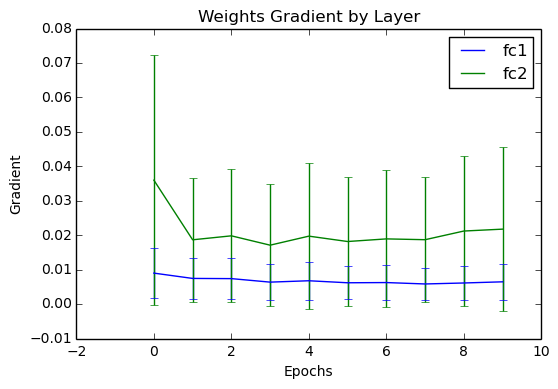

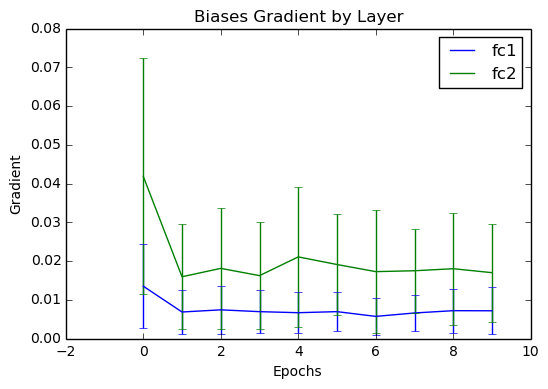

In [14]:
x = np.arange(epochs)
plt.errorbar(x,mean_gradients[0,:],std_gradients[0,:])
plt.hold(True)
plt.errorbar(x,mean_gradients[2,:],std_gradients[2,:])
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Weights Gradient by Layer')
plt.legend(["fc1","fc2"])
plt.hold(False)
plt.show()
plt.errorbar(x,mean_gradients[1,:],std_gradients[1,:])
plt.hold(True)
plt.errorbar(x,mean_gradients[3,:],std_gradients[3,:])
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Biases Gradient by Layer')
plt.legend(["fc1","fc2"])
plt.hold(False)
plt.show()